# **Sistemas de Recomendação - Content Based**

Sistemas de recomendação são aplicações práticas de Machine Learning voltadas à personalização da experiência do usuário. Seu papel é prever quais itens são mais relevantes para cada pessoa com base em padrões de comportamento e dados disponíveis. Em vez de mostrar os mesmos produtos ou conteúdos para todos, esses sistemas aprendem com as interações anteriores (como cliques, visualizações, compras) para tomar decisões automatizadas e adaptativas.

Existem diferentes abordagens para sistemas de recomendação. Nesta primeira abordagem, utilizaremos a técnica de **filtragem baseada em conteúdo (Content-Based Filtering)**, que foca nas características dos itens e no histórico individual do usuário para gerar recomendações personalizadas. Essa abordagem é especialmente útil quando há poucos dados sobre outros usuários ou quando queremos controlar melhor os critérios de recomendação.

## **Técnicas Utilizadas**
Para representar e comparar os produtos, utilizaremos duas técnicas centrais:

**TF-IDF (Term Frequency - Inverse Document Frequency):** técnica de vetorização textual que transforma descrições dos produtos em vetores numéricos. Palavras frequentes em um produto, mas raras no conjunto geral, recebem maior peso, capturando melhor os termos distintivos.

Similaridade do Cosseno (Cosine Similarity): **bold text** mede o grau de semelhança entre dois vetores, retornando um valor entre 0 e 1. Quanto mais próximo de 1, maior a semelhança entre os itens comparados no espaço vetorial.

Essas técnicas permitem representar cada produto como um vetor em um espaço de características e, a partir daí, comparar produtos entre si ou contra um vetor de preferências do usuário.

## **O QUE FAREMOS, BASICAMENTE, É:**

1. **Transformar as descrições dos produtos** (textos como nome, categoria, cor etc.) em **vetores numéricos** com técnicas de NLP.
2. **Representar os comportamentos do usuário** (visualizações, adições ao carrinho) como vetores, com pesos diferentes para cada tipo de ação.
3. **Comparar esses vetores entre si** usando álgebra linear (cálculo de similaridade) e sugerir os produtos mais próximos ao perfil do usuário.

> Como algoritmos trabalham com números, transformamos tudo em vetores. A partir disso, conseguimos **medir distâncias e similaridades matematicamente**, gerando recomendações personalizadas.

## **Importando Bibliotecas**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## **1. Carregando os Dados e Criando a Matriz Vetorial**
Nosso primeiro passo é carregar os dados dos produtos e transformá-los em um formato adequado para análise e cálculo de similaridade. Para isso, implementamos a função load_data, que realiza três tarefas principais:



1.   Leitura dos dados de produtos a partir de um arquivo CSV;
2.   Combinação das características textuais (nome, categoria, gênero, faixa etária, cor, estação e tipo) em uma única coluna;
3.   Transformação da coluna textual em uma matriz esparsa TF-IDF, onde cada linha representa um produto e cada coluna representa uma palavra relevante no corpus.

In [ ]:
def load_data(path):
    df = pd.read_csv(path)
    df.drop('image', axis=1, inplace=True)
    df['features'] = df[['name','category', 'gender', 'age_group', 'color', 'season', 'type']].fillna('').apply(
        lambda row: ' '.join([str(item) if not isinstance(item, list) else ' '.join(map(str, item)) for item in row]), axis=1)
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['features'])
    return df, tfidf_matrix

In [ ]:
df, tfidf_matrix = load_data('products.csv')

In [ ]:
df.head()

id                                  name       type  category     gender  \
0   1  Camiseta de Futebol Brasil Masculino      Roupa  Esportes  Masculino   
1   2   Camiseta de Futebol Brasil Feminino      Roupa  Esportes   Feminino   
2   3                      Chuteira Futebol    Calçado  Esportes    Unissex   
3   4                         Teclado Gamer  Acessório     Gamer    Unissex   
4   5                  Camiseta Dragon Ball      Roupa      Nerd    Unissex   

  age_group                             sizes   color season  price  \
0    Adulto                   ['P', 'M', 'G']  Padrão  Geral   89.9   
1    Adulto                   ['P', 'M', 'G']  Padrão  Geral   89.9   
2    Adulto  [37, 38, 39, 40, 41, 42, 43, 44]   Preto    NaN  219.9   
3    Adulto                               NaN  Padrão    NaN  149.9   
4    Adulto                   ['P', 'M', 'G']  Padrão  Geral   79.9   

                                            features  
0  Camiseta de Futebol Brasil Masculino Esportes ...  
1  Camiseta de Futebol Brasil Feminino Esportes F...  
2  Chuteira Futebol Esportes Unissex Adulto Preto...  
3  Teclado Gamer Gamer Unissex Adulto Padrão  Ace...  
4  Camiseta Dragon Ball Nerd Unissex Adulto Padrã...

In [ ]:
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1114 stored elements and shape (107, 152)>

## **2. Representação do Usuário com Vetores Ponderados**
Após carregar os dados e transformá-los em vetores numéricos, vamos elaborar a função get_user_vector, que será responsável por transformar o histórico de interações do usuário (armazenado em log_data) em outro vetor numérico, desta vez, o vetor que representa seu perfil de interesse.

Essa vetorização é essencial para que o sistema possa comparar o gosto do usuário com os produtos disponíveis e recomendar os mais relevantes.

### Lógica da Implementação
Cada interação registrada (como visualizar um produto ou adicioná-lo ao carrinho) tem um impacto diferente na recomendação final. Por isso, atribuímos pesos diferentes para cada tipo de ação, conforme a seguinte lógica:

In [ ]:
action_weights = {
        'view': 0.2,
        'add_to_cart': 0.7,
        'remove_from_cart': -0.3  # pode ignorar se não usar
    }

Esses pesos são definidos com base na intenção do usuário: adicionar um item ao carrinho sugere maior interesse do que apenas visualizá-lo, enquanto remover pode indicar desinteresse.

In [ ]:
def get_user_vector(log_data, df, tfidf_matrix):
    # Define os pesos das ações
    ACTION_WEIGHTS = action_weights

    vectors = []
    weights = []

    for entry in log_data:
        action = entry.get('action')
        product_id = entry.get('product_id')

        if action not in ACTION_WEIGHTS:
            continue

        weight = ACTION_WEIGHTS[action]
        index = df[df['id'] == product_id].index

        if not index.empty:
            vec = tfidf_matrix[index[0]].toarray()[0]
            vectors.append(vec * weight)
            weights.append(abs(weight))  # valor absoluto para média ponderada

    if not vectors:
        return np.zeros(tfidf_matrix.shape[1])

    user_vector = np.sum(vectors, axis=0) / np.sum(weights)
    return user_vector

#### Etapas da Função
**1. Iteração sobre o log de interações (log_data):** para cada registro, extrai-se o tipo de ação (action) e o ID do produto envolvido (product_id).

**2. Busca do vetor do produto:** o ID do produto é usado para localizar a posição correspondente na matriz TF-IDF. O vetor do produto é multiplicado pelo peso da ação e adicionado à lista de vetores do usuário.

**3. Cálculo do vetor do usuário:** Todos os vetores de produtos interagidos são somados, ponderando cada um por seu peso. A soma é dividida pela soma dos pesos absolutos, criando uma média ponderada.

**4. Fallback em caso de ausência de interações:** Se não houver interações válidas, a função retorna um vetor nulo (zero), evitando erros no cálculo de similaridade.

Esse vetor final representa os interesses agregados do usuário com base em seus comportamentos anteriores, e será utilizado na próxima etapa para calcular a similaridade entre o usuário e os produtos disponíveis.

In [ ]:
def get_recommendations_from_vector(user_vector, df, tfidf_matrix, top_n=5):
    similarities = cosine_similarity([user_vector], tfidf_matrix).flatten()
    df_copy = df.copy()
    df_copy['similarity'] = similarities
    return df_copy.sort_values('similarity', ascending=False).head(top_n)

## **3. Geração de Recomendações a partir do Vetor do Usuário**


Após termos construído o vetor que representa o comportamento do usuário com base nas interações registradas (user_vector), o próximo passo é encontrar quais produtos do catálogo são mais parecidos com esse vetor, ou seja, quais itens mais se alinham com os interesses demonstrados por esse usuário.

A função get_recommendations_from_vector realiza exatamente isso:

In [ ]:
def get_recommendations_from_vector(user_vector, df, tfidf_matrix, top_n=5):
    similarities = cosine_similarity([user_vector], tfidf_matrix).flatten()
    df_copy = df.copy()
    df_copy['similarity'] = similarities
    return df_copy.sort_values('similarity', ascending=False).head(top_n)

Etapas realizadas:
Cálculo da Similaridade

1. Cálculo da Similaridade
2. Criação de uma cópia do DataFrame
3. Ordenação e Seleção dos Top-N produtos

## **4. Cálculo das Métricas de Performance**
Avaliar a qualidade de um sistema de recomendação é uma etapa essencial no desenvolvimento de soluções baseadas em Machine Learning. Nosso desafio é realizar esta avaliação em um cenário onde não dispomos de dados reais de usuários reais, de cliques, ratings ou compras, como é o caso deste projeto.

Diante da ausência de dados de avaliação reais, optei por uma avaliação qualitativa simulada, onde eu assumo o papel de diferentes perfis de usuário e observo se as recomendações geradas fazem sentido dentro daquele contexto.

#### Etapas da Avaliação:
1. Escolher um perfil simulado de usuário
2. Simular comportamentos no site
3. Acessar as recomendações personalizadas
4. Anotar os produtos recomendados

Mesmo que seja uma avaliação manual, podemos aplicar **métricas simples** com base na percepção de coerência:

- **Precision (Precisão)**  
$$\text{Precision} = \frac{\text{Número de itens relevantes recomendados}}{\text{Número total de itens recomendados}}
$$

#### Exemplo:

Se entre 8 produtos recomendados, 6 são coerentes com o perfil do usuário:

$$
\text{Precision} = \frac{6}{8} = 0{,}75 \quad \Rightarrow \quad 75\%
$$

Essa avaliação é **subjetiva**, mas ainda assim **muito útil** para observar **tendências de erro** do modelo e entender a **coerência semântica** das recomendações, além de averiguar possível necessidade de evoluções como: filtragem híbrida, feedback explícito, clusterização de perfis, entre outras abordagens.

###**Perfil simulado 1: Cliente Esportista Feminina**
* **Gênero:** Feminino
* **Faixa etária:** Adulto
* **Interesses:** Atividades físicas, corrida, academia, estilo esportivo
* **Produtos que simularemos adicionar ao carrinho:** Tênis de corrida feminino, Calça legging, Top esportivo, Jaqueta corta-vento, Garrafa squeeze, etc.
* **Expectativa nas recomendações:** Mais itens de moda esportiva feminina; Produtos relacionados a corrida e fitness.

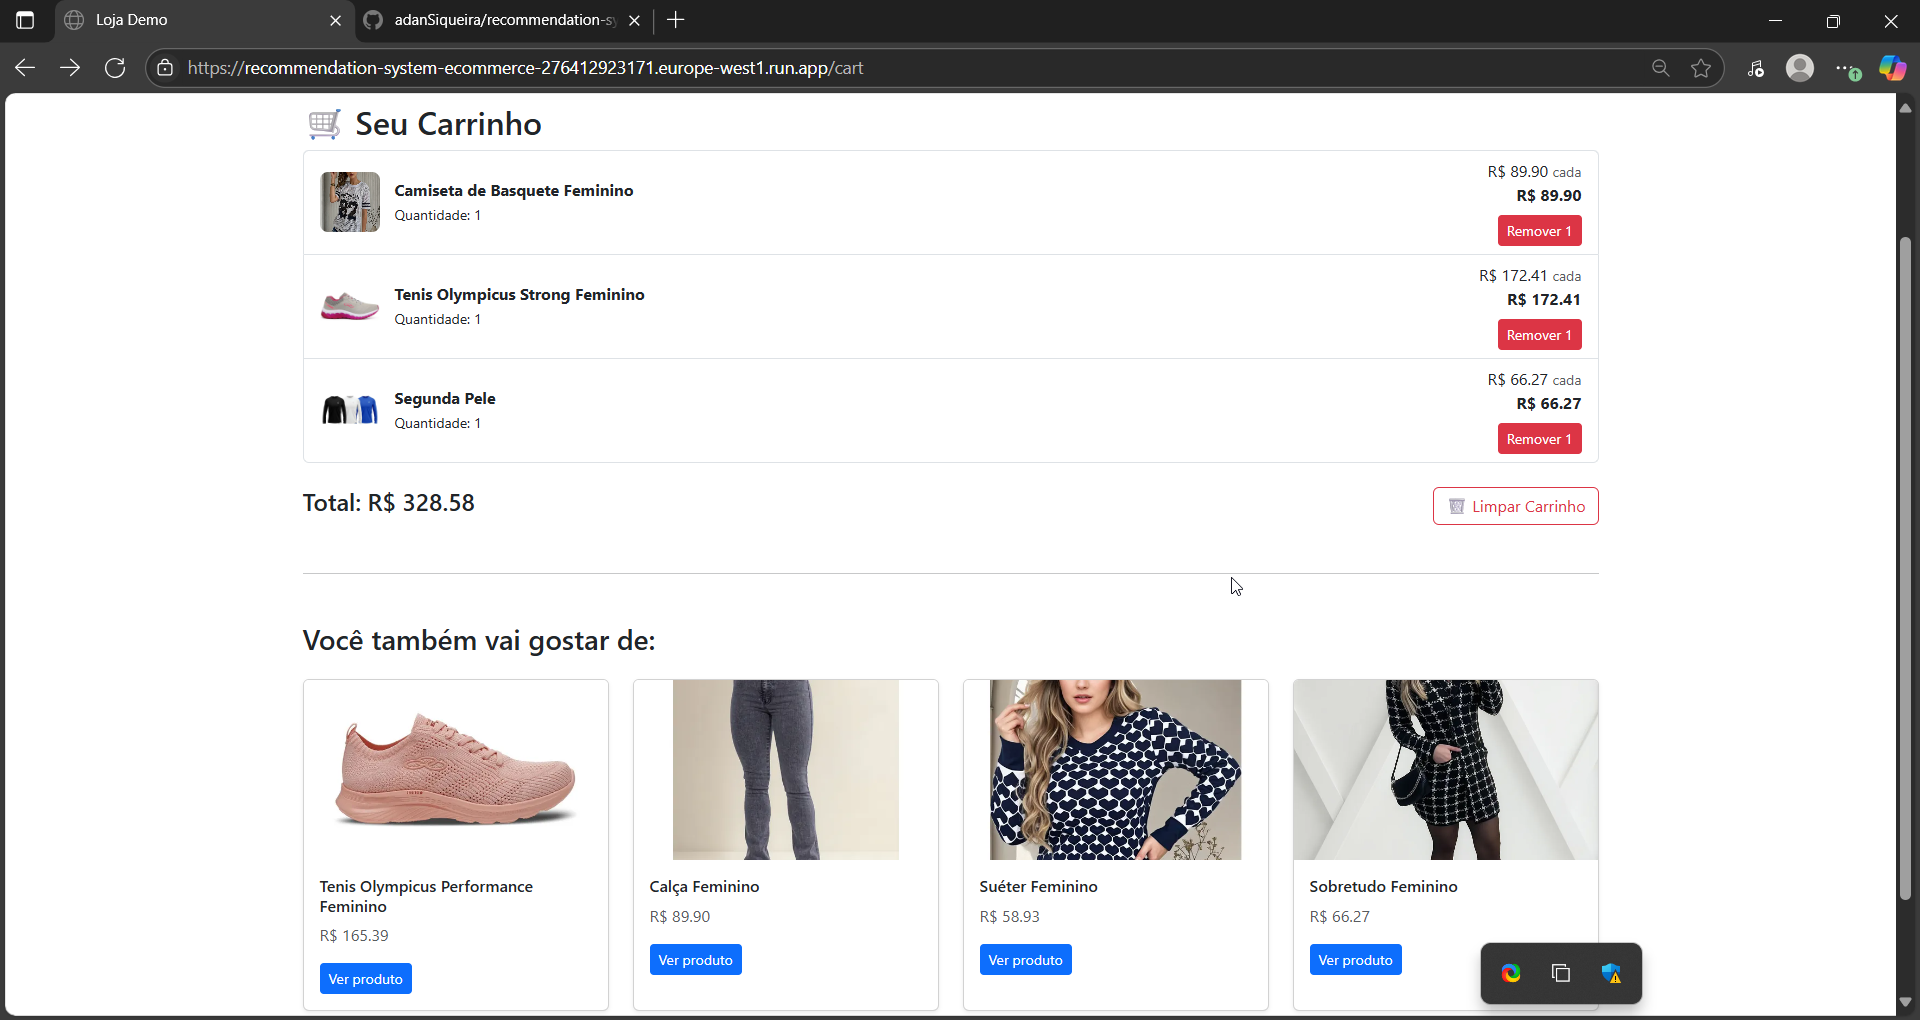

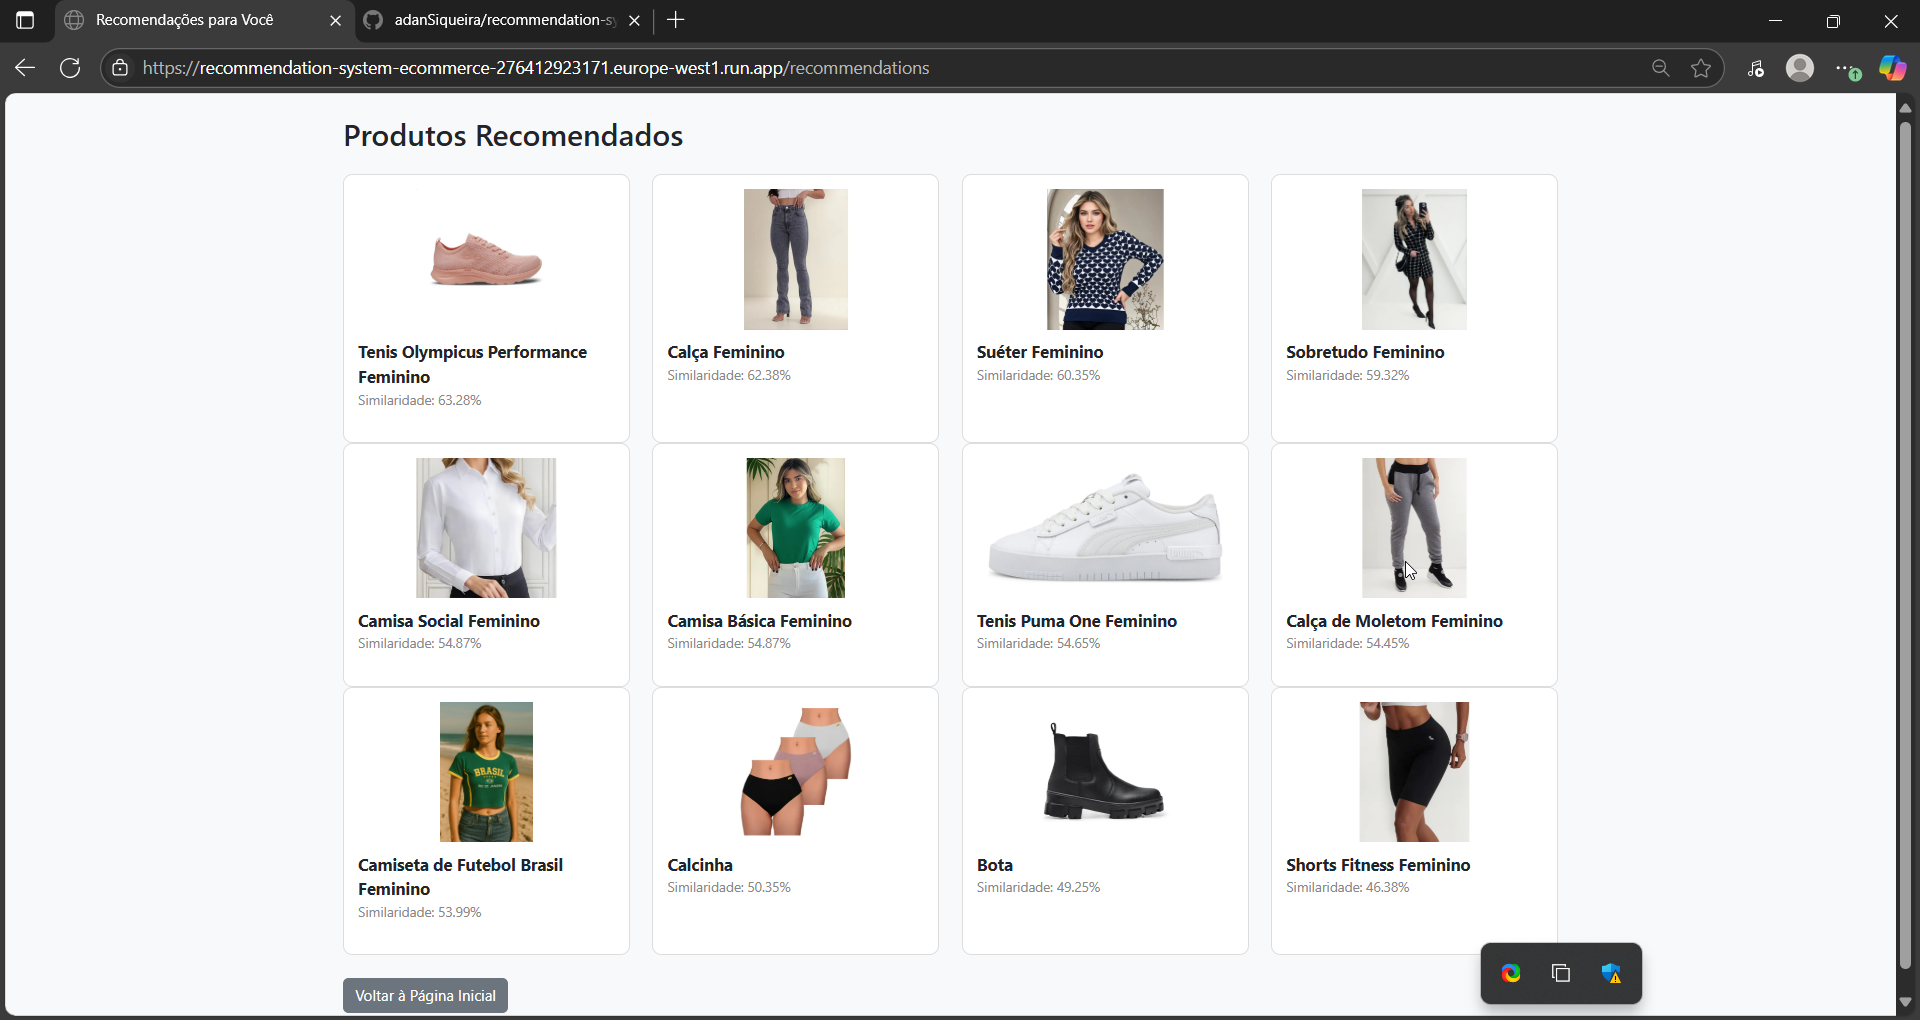

#### **"Você também vai gostar de: "** :

Entre 4 produtos recomendados, 4 são coerentes com o perfil do usuário.

$$
\text{Precision} = \frac{4}{4} = 1{,}00 \quad \Rightarrow \quad 100\%
$$


#### **"Produtos Recomendados: "** :
Entre 12 produtos recomendados, 12 são coerentes com o perfil do usuário.

$$
\text{Precision} = \frac{12}{12} = 1{,}00 \quad \Rightarrow \quad 100\%
$$

### **Perfil simulado 2: Cliente Geek Masculino Jovem**  
* **Gênero:** Masculino  
* **Faixa etária:** Jovem adulto (18–30 anos)  
* **Interesses:** Cultura pop, filmes, HQs, animes, jogos  
* **Produtos que simularemos adicionar ao carrinho:** Camiseta da Marvel, Moletom do Naruto, Caneca de Star Wars, Action figure do Batman, Boné do Homem de Ferro  
* **Expectativa nas recomendações:** Produtos temáticos; Itens relacionados a personagens, franquias e cultura geek.

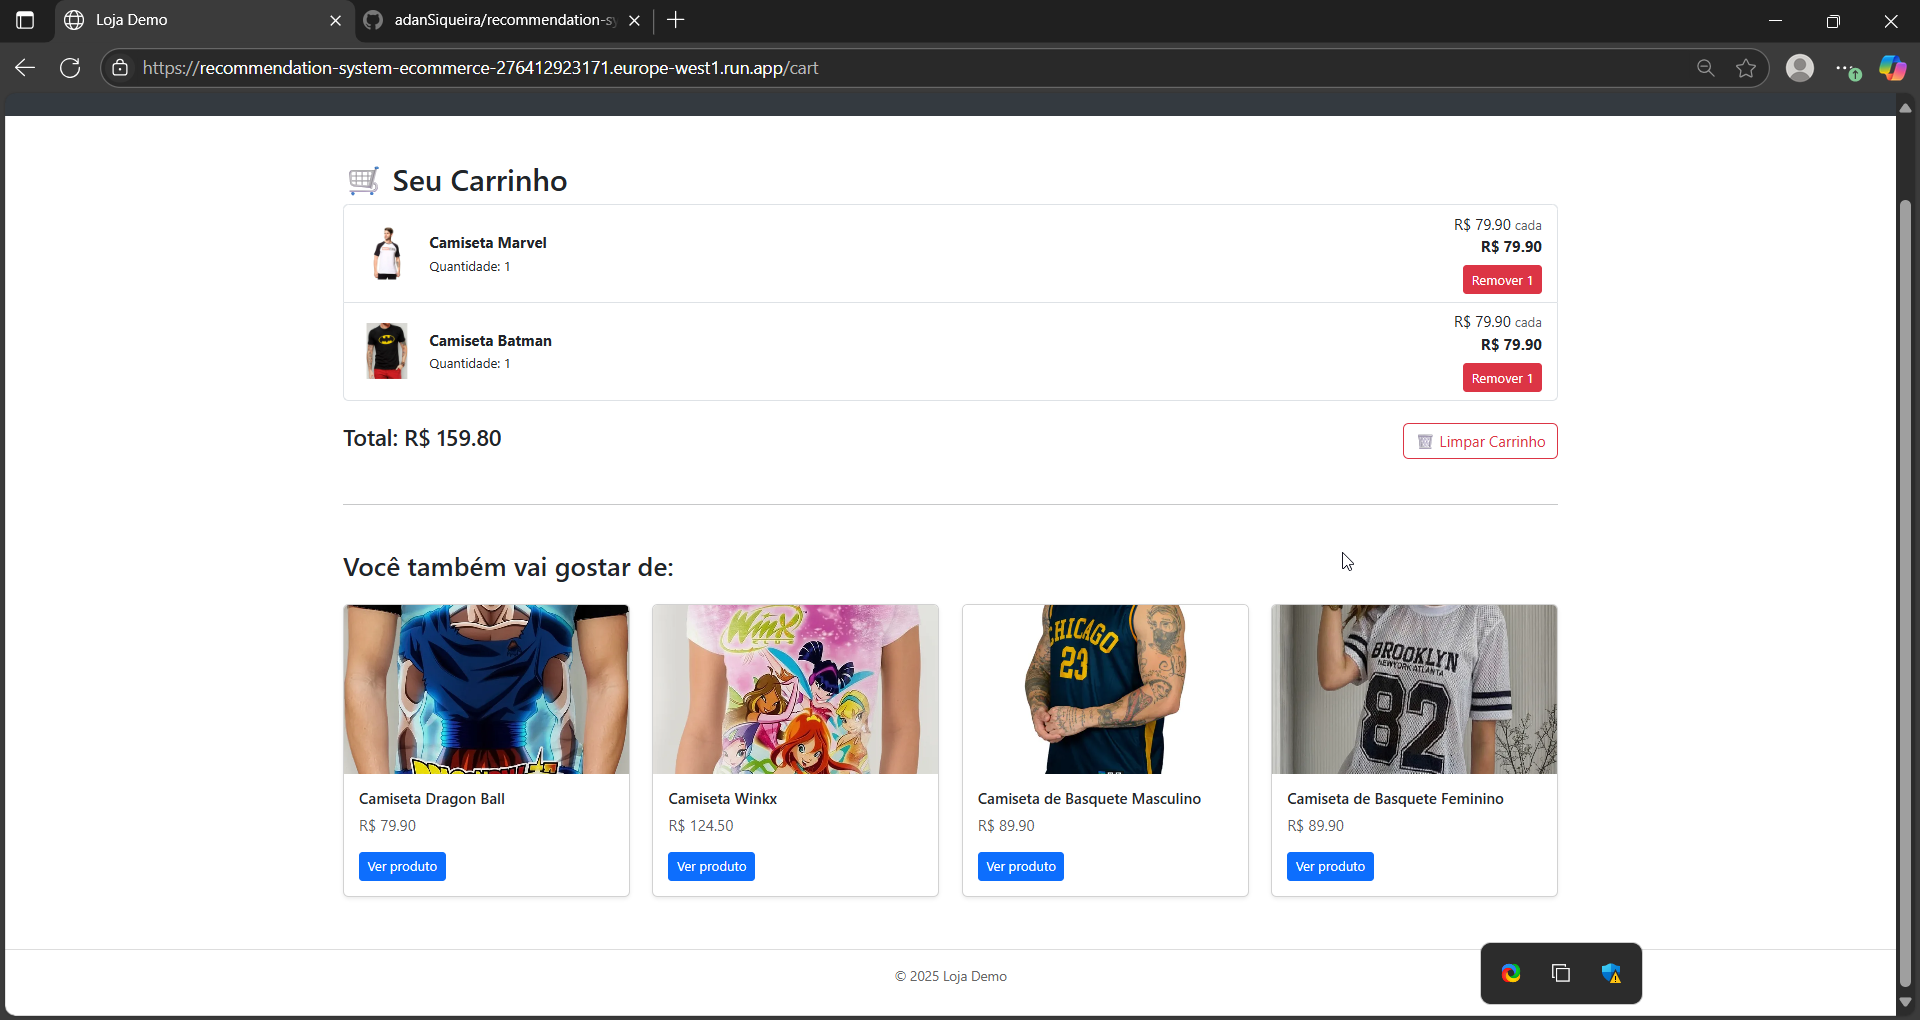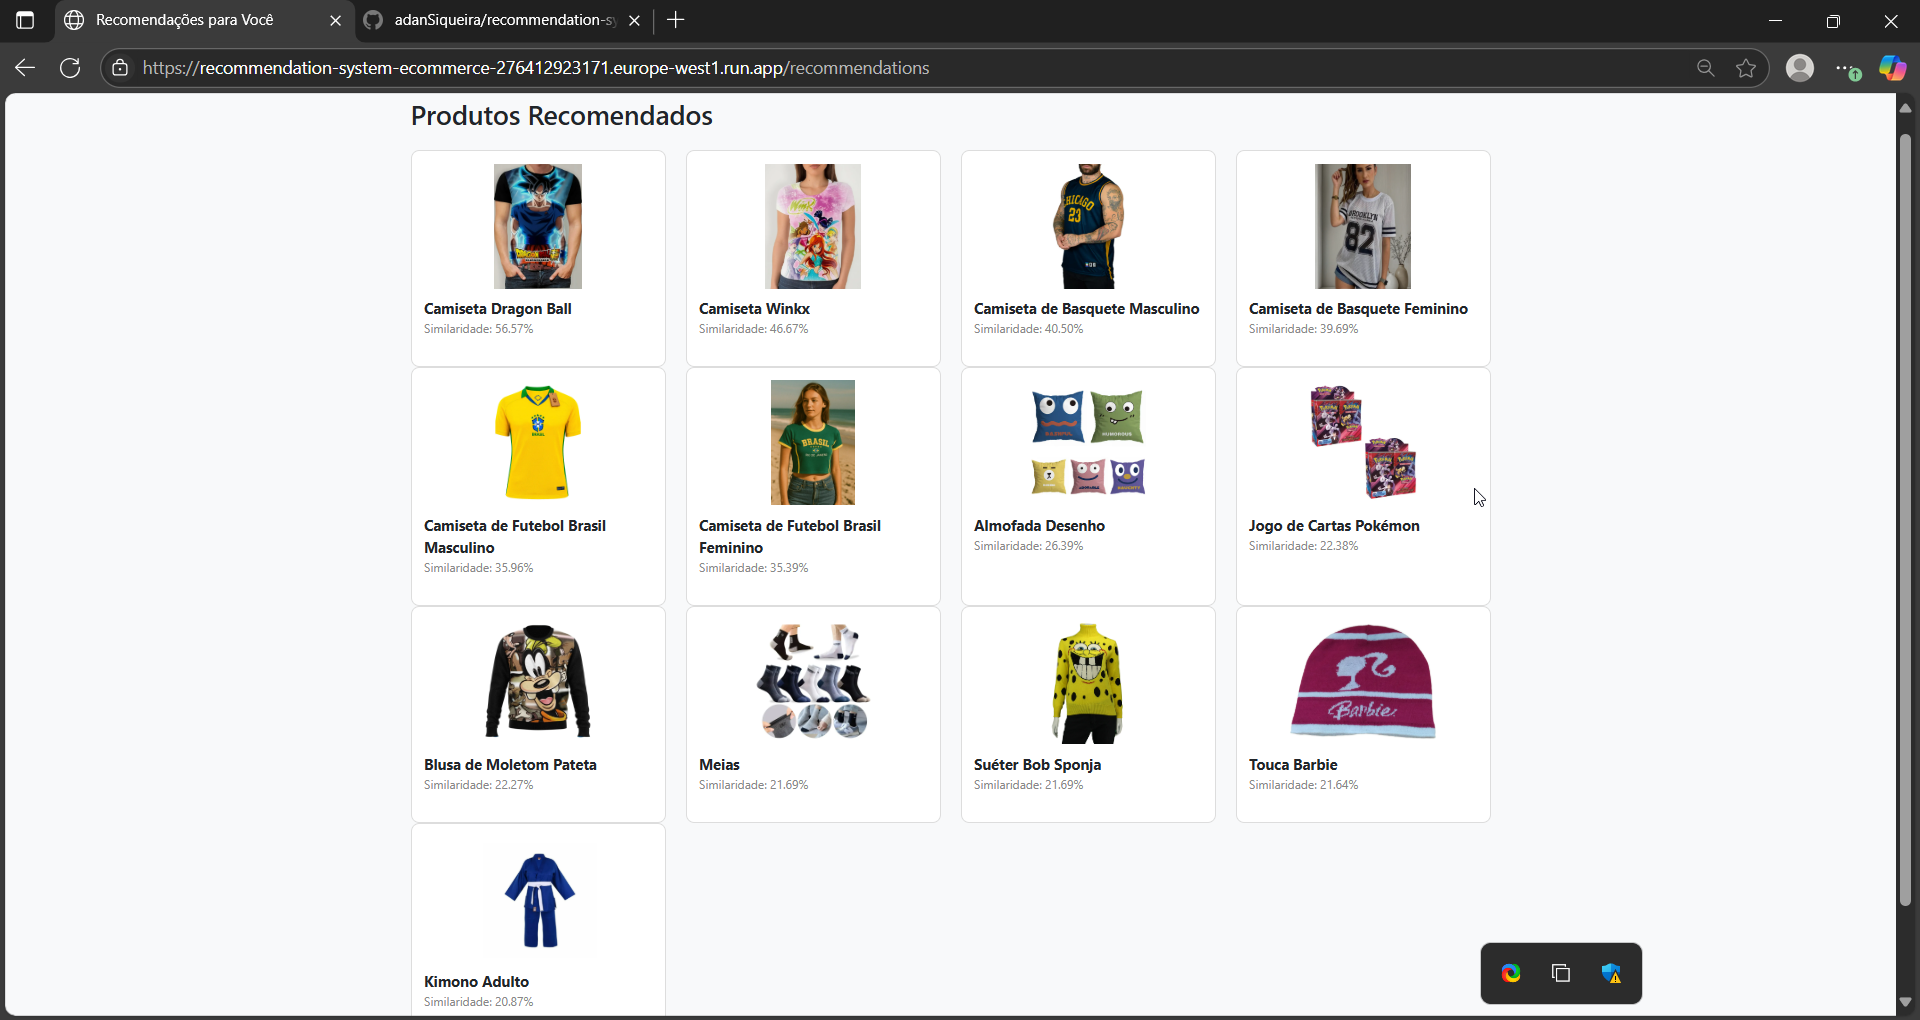

#### **"Você também vai gostar de: "** :

Entre 4 produtos recomendados, 4 são coerentes com o perfil do usuário.

$$
\text{Precision} = \frac{2}{4} = 0{,}50 \quad \Rightarrow \quad 50\%
$$


#### **"Produtos Recomendados: "** :
Entre 12 produtos recomendados, 12 são coerentes com o perfil do usuário.

$$
\text{Precision} = \frac{4}{12} = 0{,}33 \quad \Rightarrow \quad 33\%
$$

### **Perfil simulado 3: Mãe Comprando para Criança**  
* **Gênero:** Feminino  
* **Faixa etária:** Adulto (comprando para faixa etária infantil)  
* **Interesses:** Moda infantil, conforto, personagens infantis, material escolar  
* **Produtos que simularemos adicionar ao carrinho:** Conjunto infantil com estampa, Mochila escolar, Sandália infantil, Camiseta com desenhos, Estojo escolar  
* **Expectativa nas recomendações:** Mais itens voltados para o público infantil; Roupas com estampas divertidas, acessórios escolares.

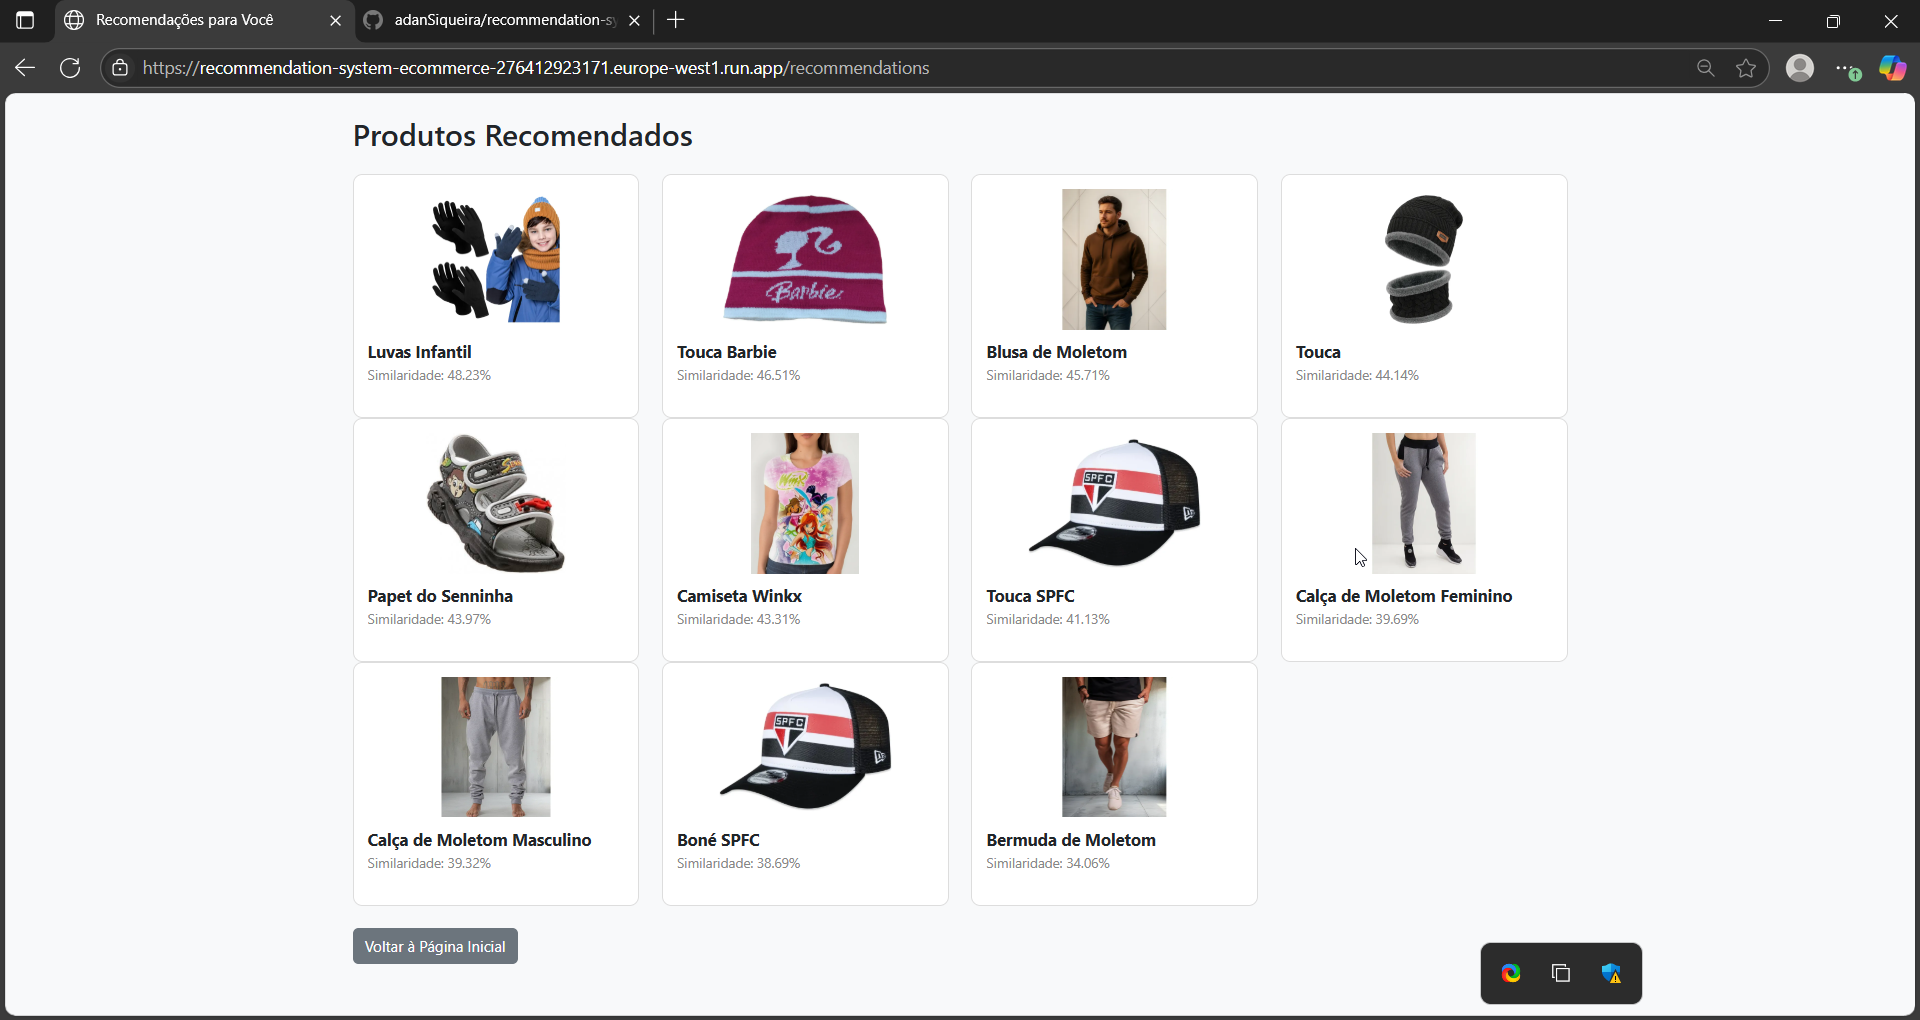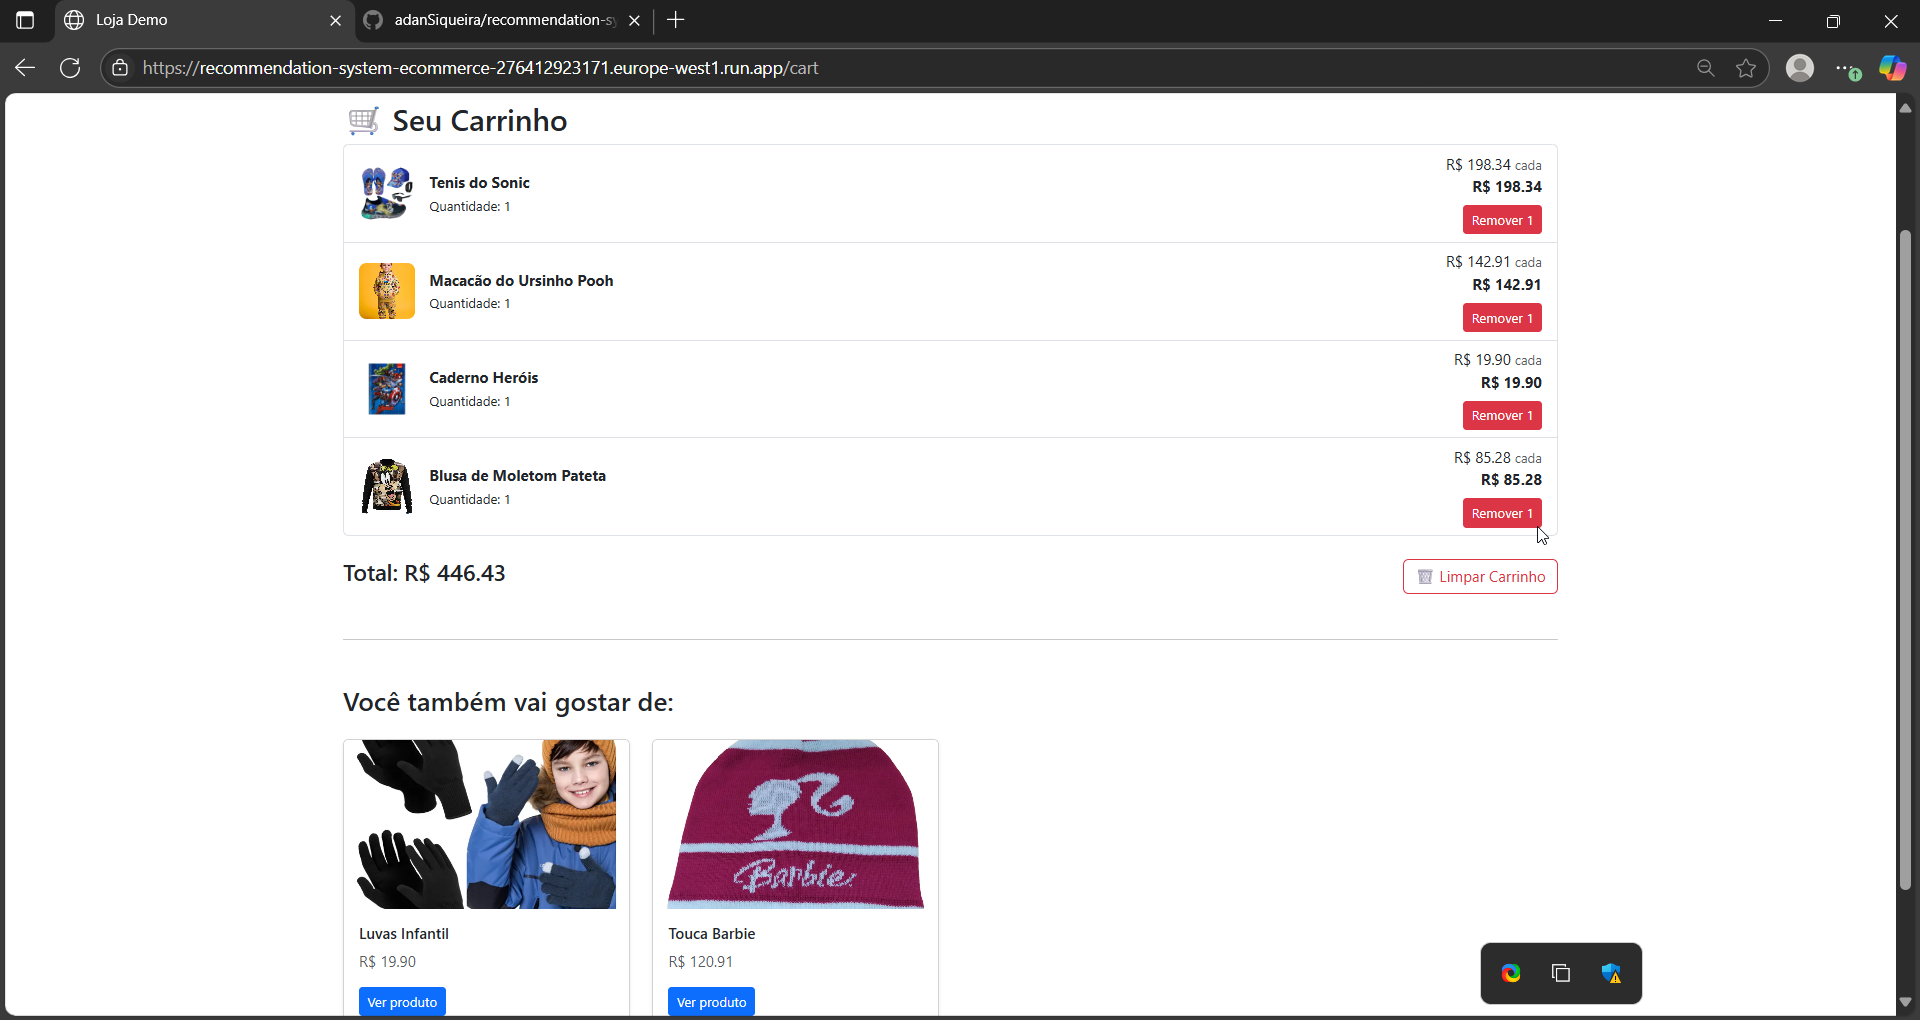

#### **"Você também vai gostar de: "** :

Entre 2 produtos recomendados, 1 é coerente com o perfil do usuário.

$$
\text{Precision} = \frac{2}{2} = 1{,}00 \quad \Rightarrow \quad 100\%
$$


#### **"Produtos Recomendados: "** :
Entre 12 produtos recomendados, 12 são coerentes com o perfil do usuário.

$$
\text{Precision} = \frac{5}{11} = 0{,}45 \quad \Rightarrow \quad 45\%
$$

### **Perfil simulado 4: Cliente Jovem Fashionista**  
* **Gênero:** Feminino  
* **Faixa etária:** Jovem adulta (18–25 anos)  
* **Interesses:** Moda urbana, tendências, looks de influenciadores  
* **Produtos que simularemos adicionar ao carrinho:** Jaqueta jeans oversized, Cropped, Calça cargo, Bota plataforma, Bolsa de ombro  
* **Expectativa nas recomendações:** Peças estilosas, modernas, casuais com tendência streetwear; looks combináveis.  

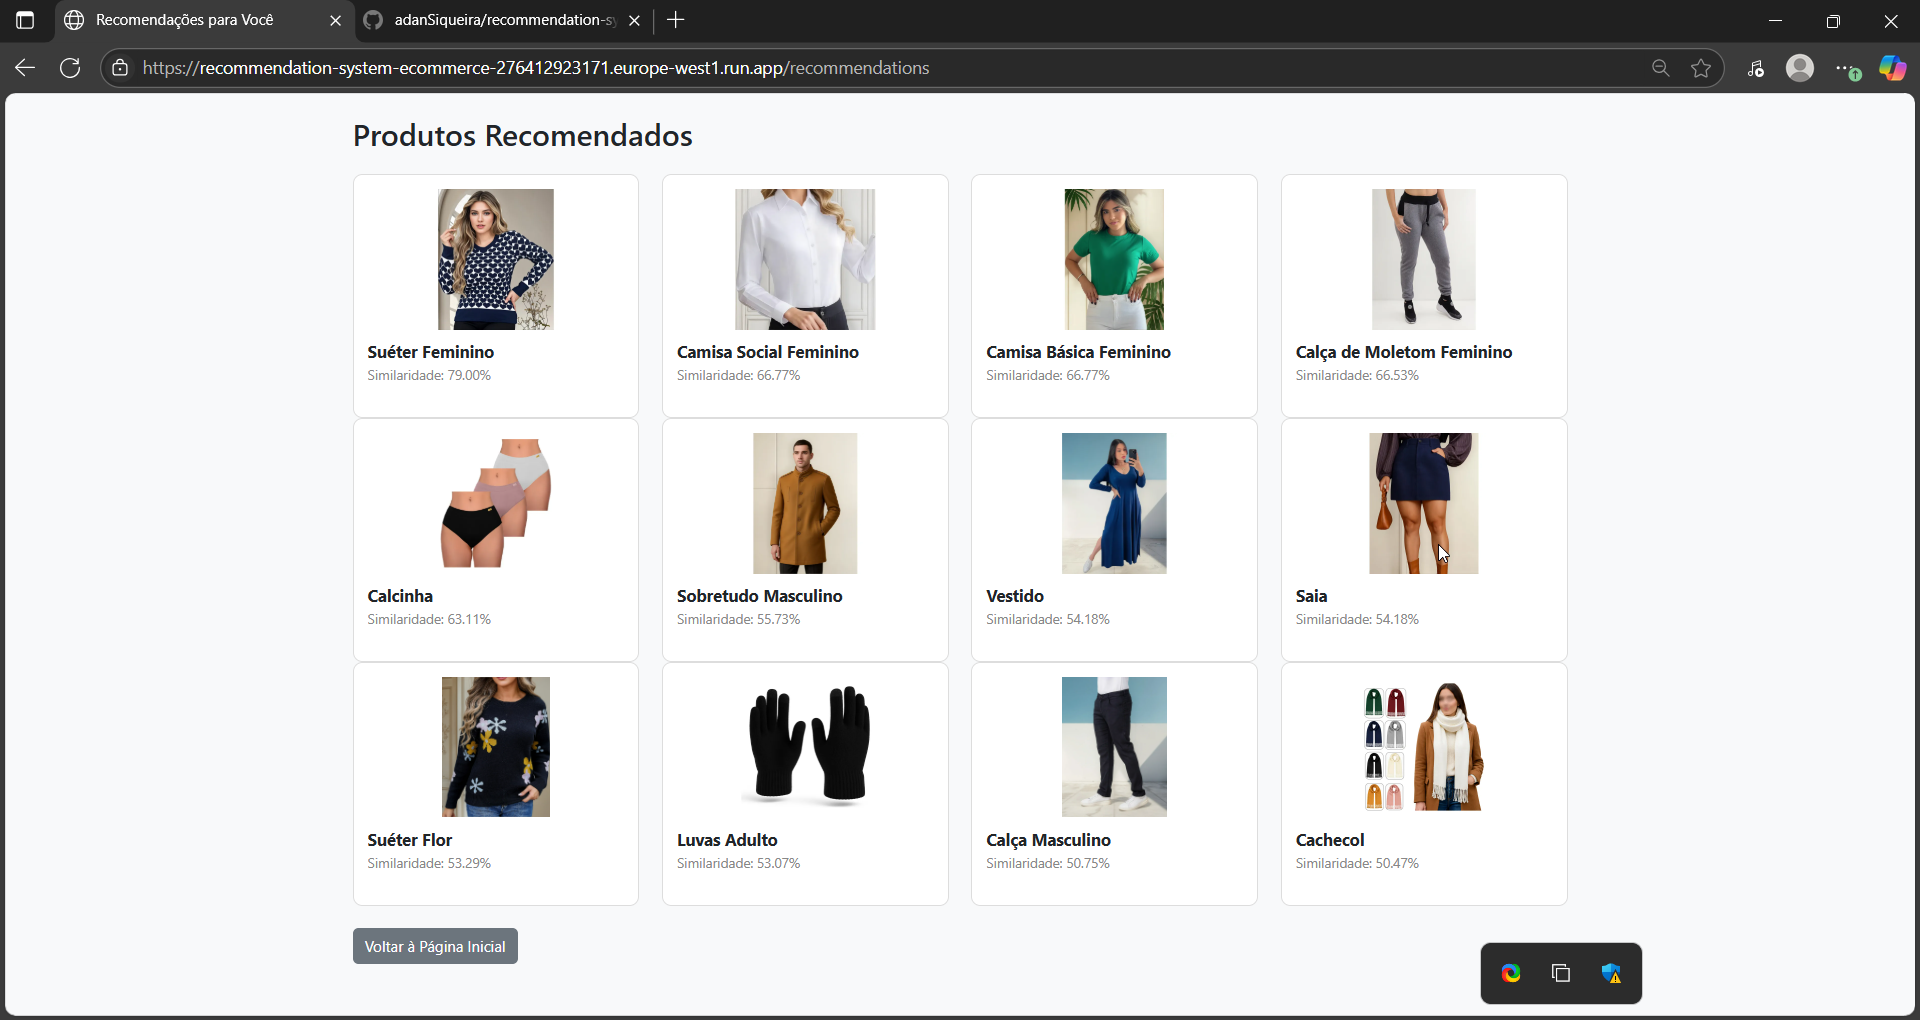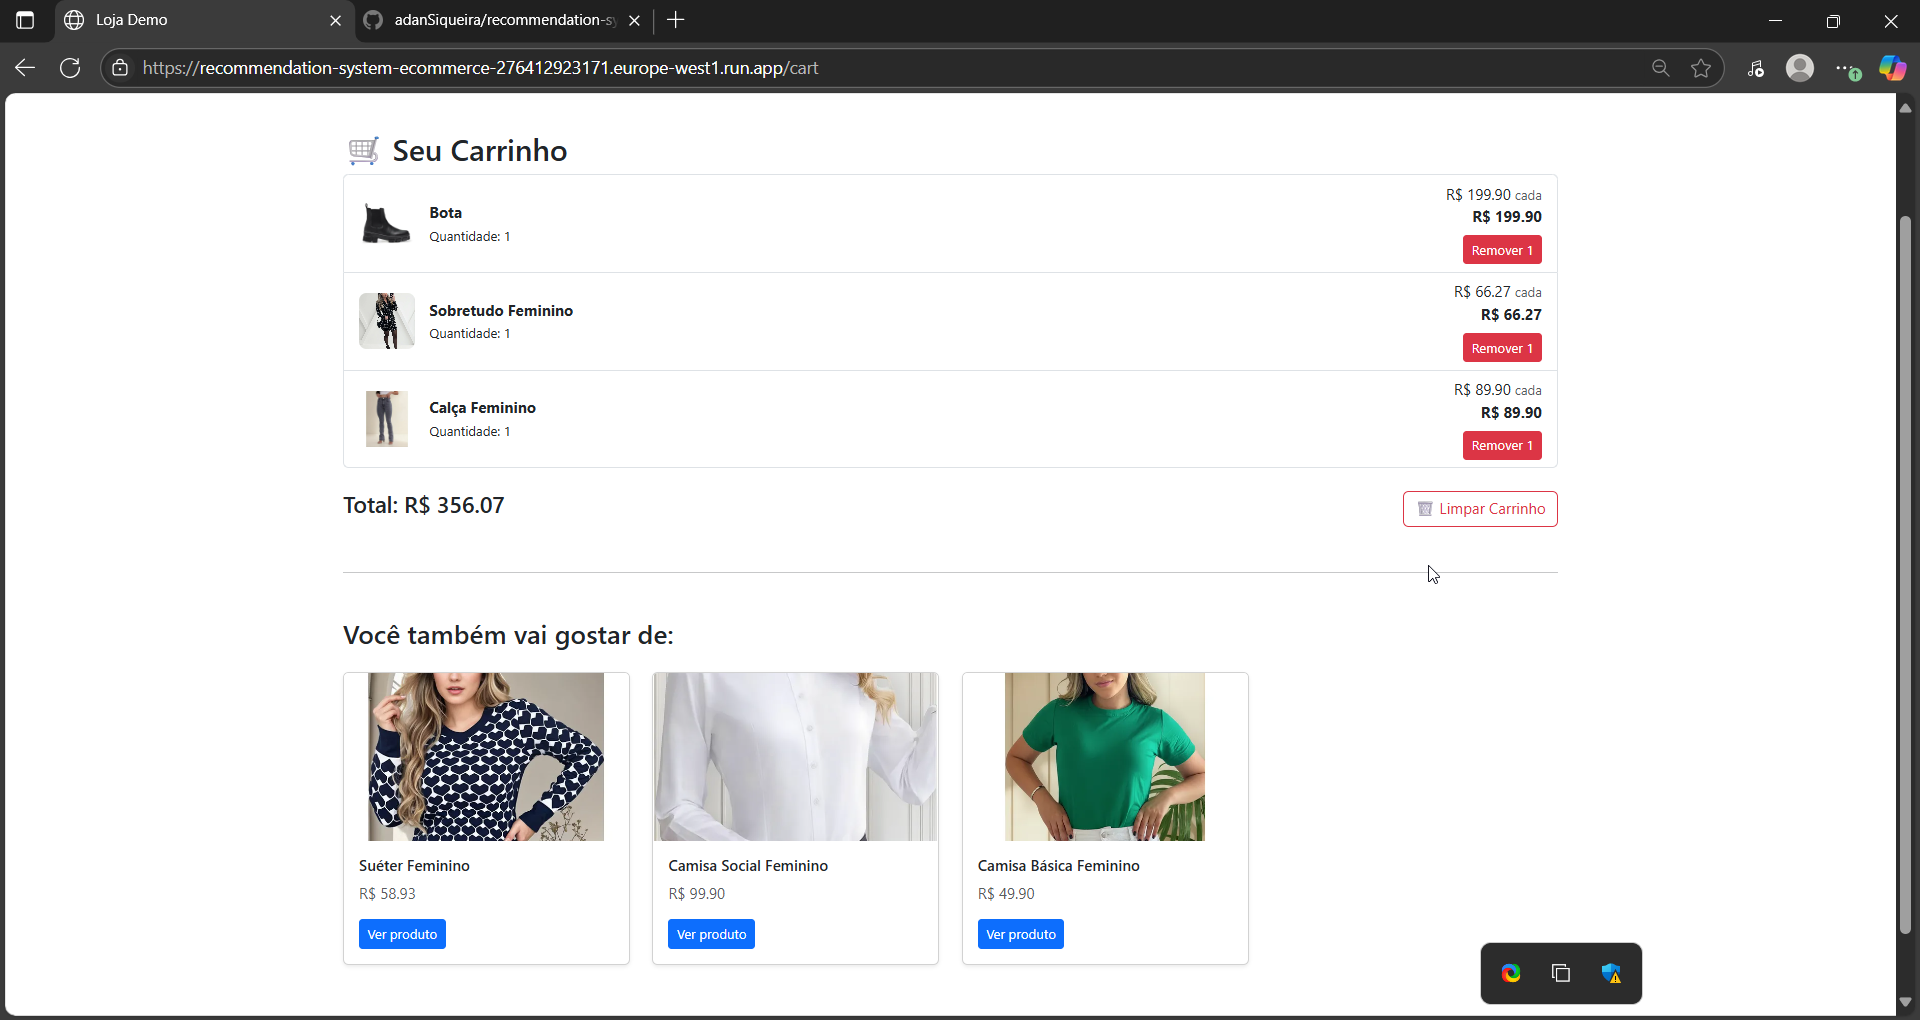

#### **"Você também vai gostar de: "** :

Entre 2 produtos recomendados, 1 é coerente com o perfil do usuário.

$$
\text{Precision} = \frac{3}{3} = 1{,}00 \quad \Rightarrow \quad 100\%
$$


#### **"Produtos Recomendados: "** :
Entre 12 produtos recomendados, 12 são coerentes com o perfil do usuário.

$$
\text{Precision} = \frac{8}{12} = 0{,}75 \quad \Rightarrow \quad 75\%
$$

### **Perfil simulado 5: Cliente Casual Masculino Básico**  
* **Gênero:** Masculino  
* **Faixa etária:** Adulto  
* **Interesses:** Roupas confortáveis e básicas, uso diário, estilo casual  
* **Produtos que simularemos adicionar ao carrinho:** Camiseta lisa, Bermuda jeans, Tênis branco básico, Cuecas de algodão, Meias esportivas  
* **Expectativa nas recomendações:** Mais roupas casuais, confortáveis e neutras; foco em praticidade e dia a dia.

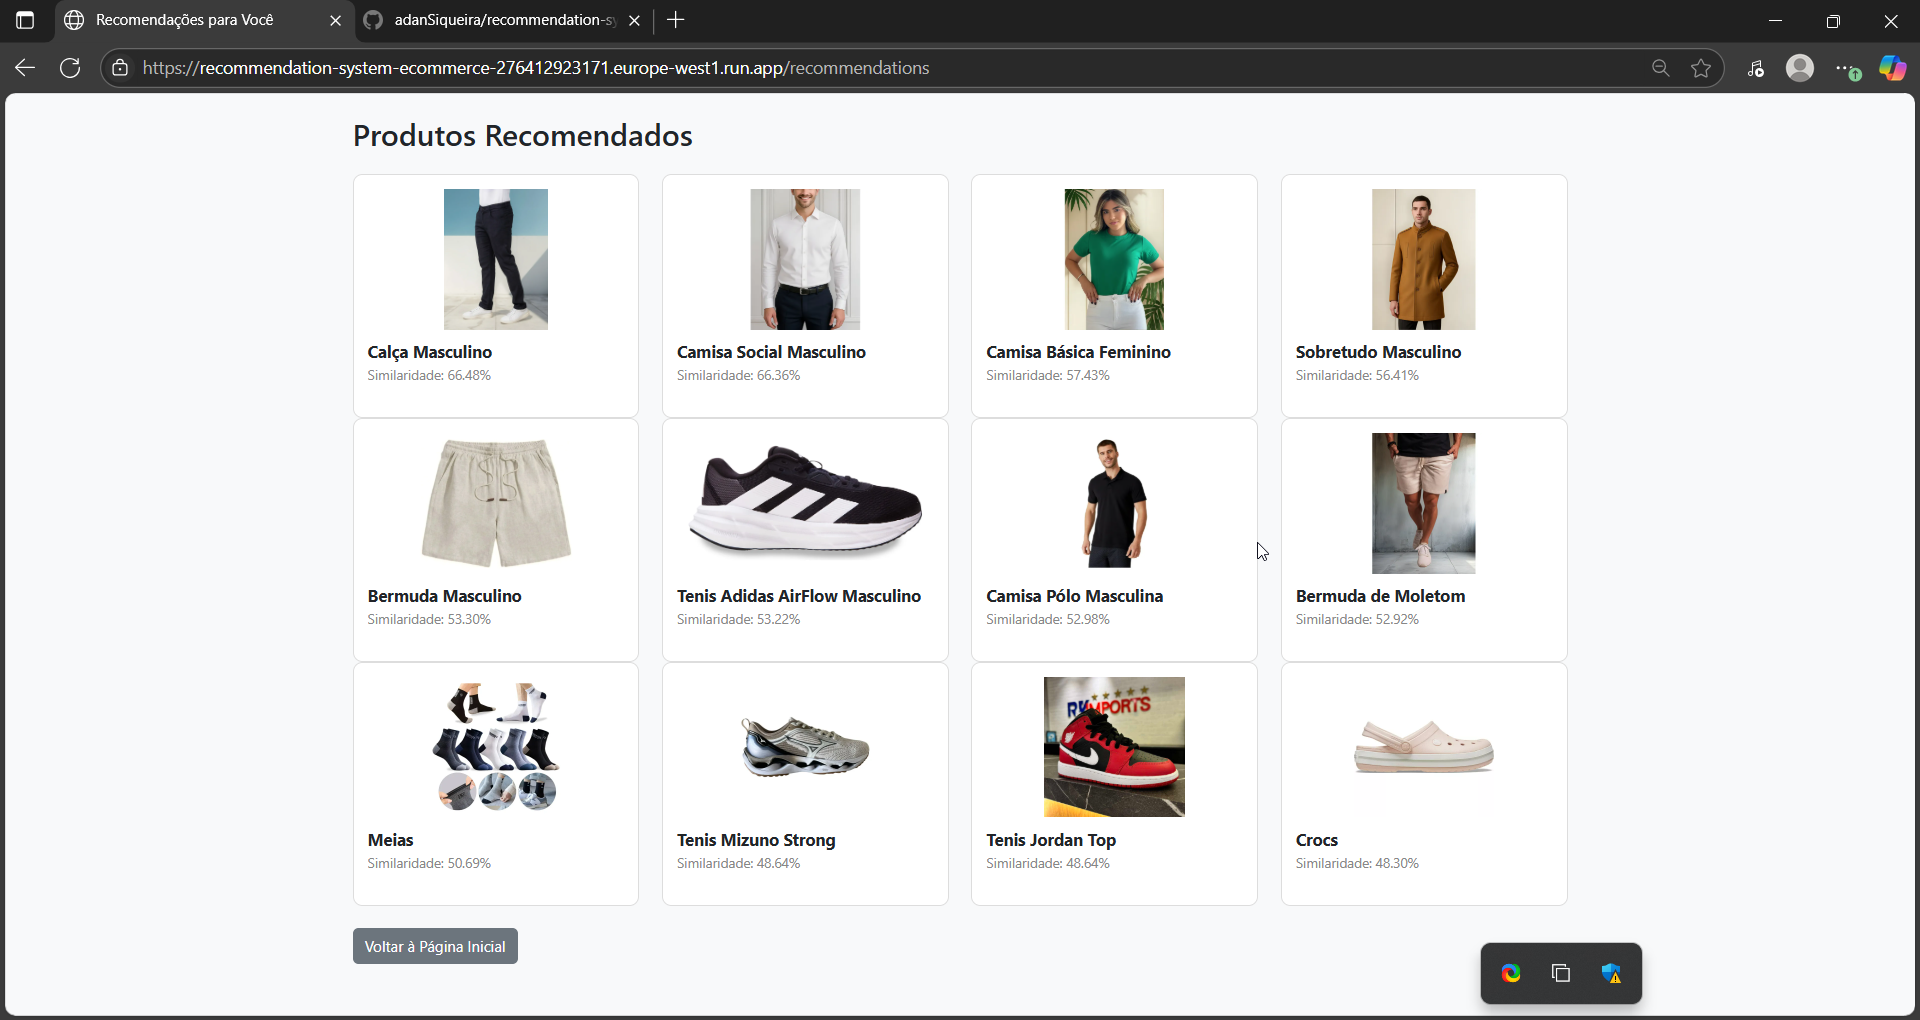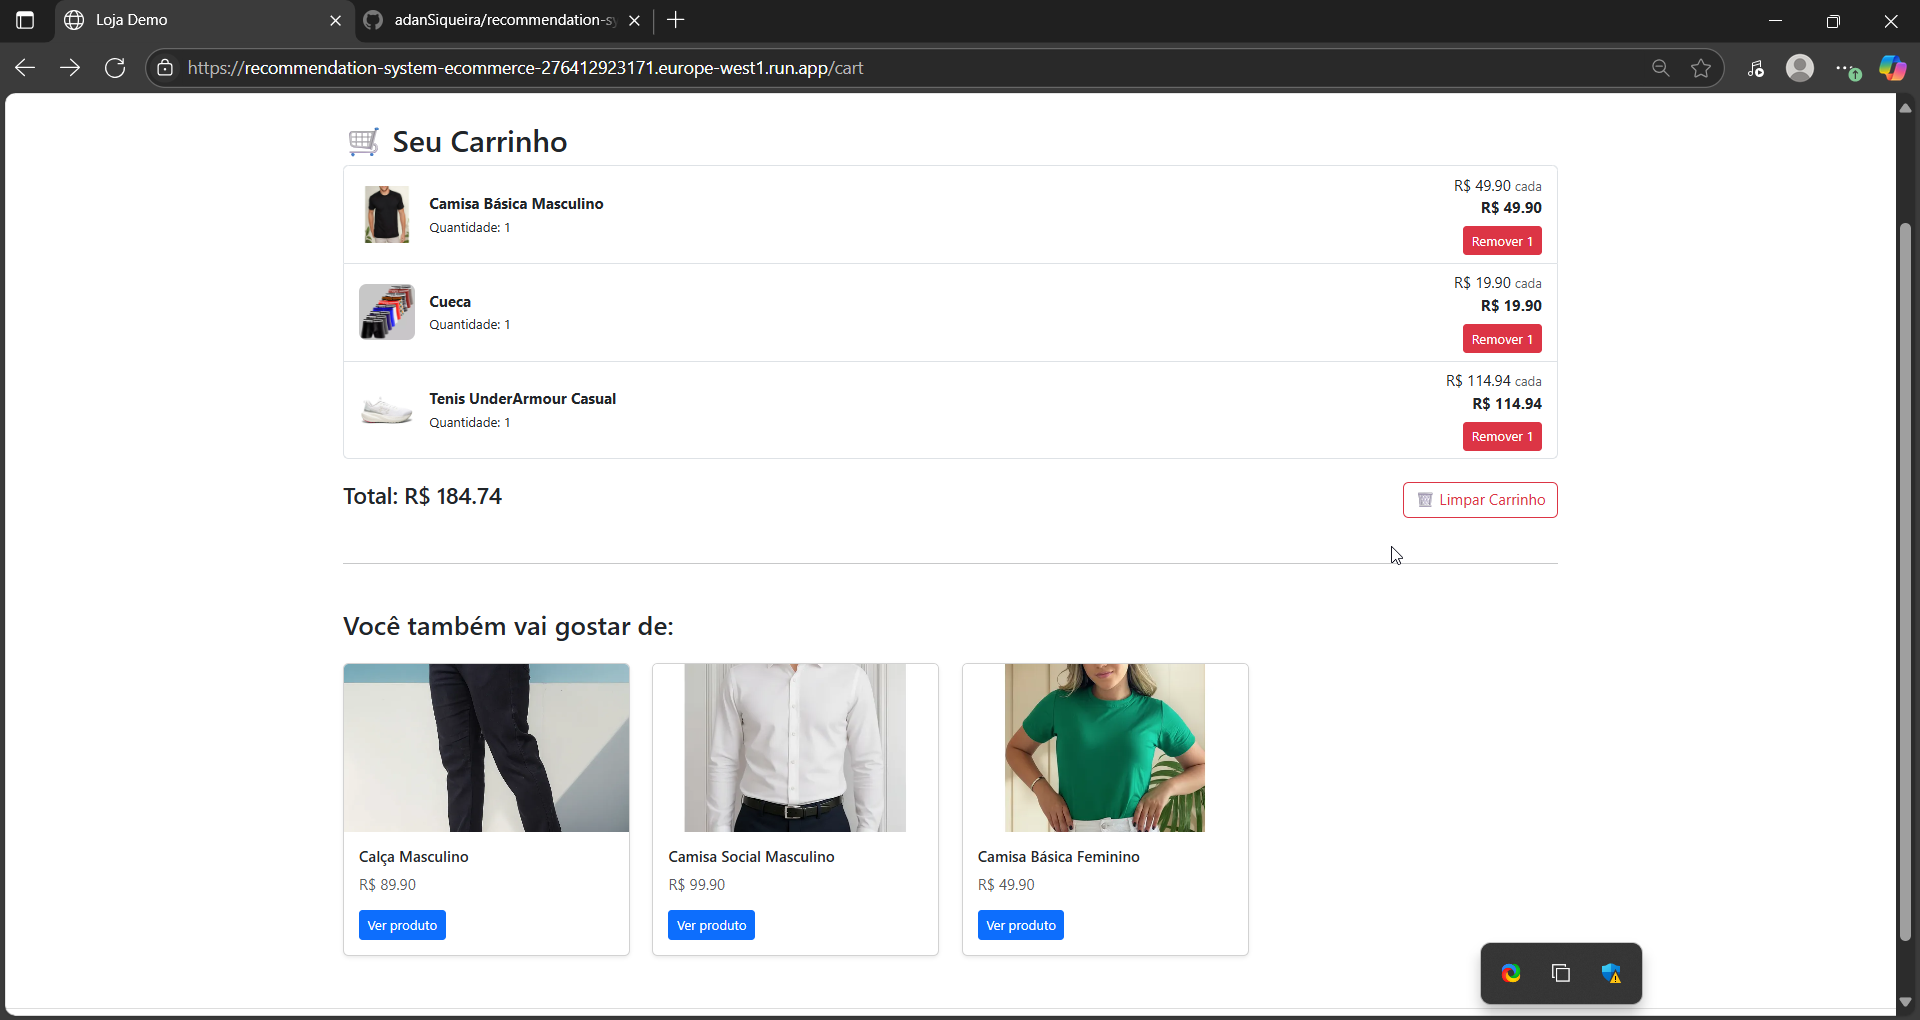

#### **"Você também vai gostar de: "** :

Entre 2 produtos recomendados, 1 é coerente com o perfil do usuário.

$$
\text{Precision} = \frac{2}{3} = 0{,}66 \quad \Rightarrow \quad 66\%
$$


#### **"Produtos Recomendados: "** :
Entre 12 produtos recomendados, 12 são coerentes com o perfil do usuário.

$$
\text{Precision} = \frac{9}{12} = 0{,}75 \quad \Rightarrow \quad 75\%
$$

##**5. Avaliando as Métricas**

### Resultados obtidos:

| Perfil Simulado                       | Carrinho (%) | Página /recommendations (%) |
|--------------------------------------|--------------|------------------------------|
| Cliente Esportista Feminina          | 100%         | 100%                         |
| Cliente Geek Masculino Jovem         | 50%          | 33%                          |
| Mãe Comprando para Criança           | 100%         | 45%                          |
| Cliente Jovem Fashionista            | 100%         | 75%                          |
| Cliente Casual Masculino Básico      | 66%          | 75%                          |


### **Interpretação dos Resultados**

- **Perfis 1, 3 e 4** obtiveram excelente desempenho, com recomendações altamente coerentes com seus interesses. Isso indica que o modelo está conseguindo capturar bem os padrões de atributos textuais desses produtos (ex: esportivo, infantil e fashion).
- **Perfil 2 (Geek)** teve desempenho mais fraco. A queda na precisão pode indicar que os atributos textuais usados (nome, tipo, categoria etc.) são insuficientes para distinguir produtos temáticos/geek de forma eficaz — ou ainda que o modelo está confundindo semelhanças semânticas superficiais com interesse real.
- **Perfil 5** teve desempenho razoável. Produtos básicos, por sua natureza genérica, podem ser parecidos entre si e com outros itens, o que pode fazer com que a recomendação "saia da linha" em alguns casos.


### **Considerações Finais**

Embora essa abordagem não substitua testes quantitativos com usuários reais (como métricas de conversão, CTR, A/B testing), ela é extremamente útil em fases iniciais de prototipagem. O ideal seria, futuramente, combinar essas análises com **métricas baseadas em dados reais de uso**, caso estejam disponíveis.